# 1. Introduction

In this project, our group implemented a convolutional neural network (CNN) to recognize handwritten digits. Because none of the team members had implemented a neural network before, our first goal was to create a simple network that is somewhat capable of recognizing the images.

Firstly, the document will introduce how was the simple neural network built and showcase the initial results for recognizing digits. Secondly, the document will explain how our CNN model was built and implement a technique for tuning the hyper parameters called Grid Search, that we use to find the hyper parameters for our CNN. 

The document will also include an external CNN model that was found online. This will be used for comparing it to our basic model and our CNN model to test which one performs the best.

Lastly, the document will also discuss the related work done in the same domain and discuss the ethical impact of neural networks for handwritten digit recognition.

# 2. Neural network

The following section will introduce our implementation of the neural network. The section will also cover the results such as how well did the network learn about the dataset and was it able to accurately predict the digits.

The implementation of our neural network was inspired by a third-party source [1] which introduces how to implement a neural network to people who are new to the topic. Therefore, certain variables such as the batch sizes, the learning rate as well as the momentum were kept the same. This was due to the fact that even when we slightly changed the numbers, it did not have an impact on the final results.

## 2.1 Initializing and loading the data set

First, we import all the libraries which we will be using for the project.

In [163]:
import numpy as np
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from IPython.display import HTML, Image, display
import random
import itertools
from time import time
import gc
import json

In [159]:
# Use a constant seed for randomness so that reruns becomes predictable
random_seed = 1
torch.manual_seed(random_seed)

torch.backends.cudnn.enabled = False

Pytorch already have a predefined function for loading the MNIST dataset which we will be using. In addition to that the following code converts the images to Pytorch tensors and normalizes the pixels to values in the range \[0, 1\].

In [160]:
# How many images to feed through the network each time
batch_size_train = 64
batch_size_test = 64

training_set = torch.utils.data.DataLoader(torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                             torchvision.transforms.Normalize((0.5,), (0.5,))])),batch_size=batch_size_train, shuffle=True)

test_set = torch.utils.data.DataLoader(torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.5,), (0.5,))])),batch_size=batch_size_test, shuffle=True)

In [179]:
print(len(training_set))

938


Inspecting the first tensor from the training set, we can see that it has the dimensionality of 64 x 1 x 28 x 28, where 64 is the number of images in that batch and the 28x28 is the width and height of the images in pixels

In [161]:
examples = enumerate(training_set)
_, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([64, 1, 28, 28])

The code block below plots different numbers from the dataset along with their labels. This is a way to show that everyone has a different handwriting and the network should be capable of recognizing most of the numbers.

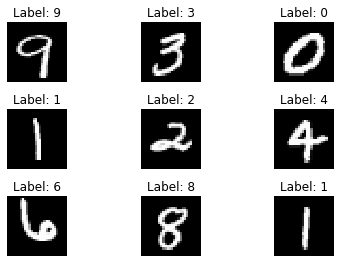

In [128]:
def plot_grayscale_images(m, n, images, labels):
    fig = plt.figure()
    for i in range(m * n):
        plt.subplot(m, n, i + 1)
        plt.tight_layout()
        plt.imshow(images[i][0], cmap='gray', interpolation='none')
        plt.title("Label: {}".format(labels[i]))
        plt.axis('off')
        
plot_grayscale_images(3, 3, example_data, example_targets)

## 2.2 Creating a basic model

The structure of our basic model is a 784 node input layer (the size of an image when converted to a vector) connected to a 50 node hidden layer with the ReLU activation function and a 10 node output layer. For the hidden layer we tried various ranges between the input and output layer sizes but we realized that searching for hyper parameters manually is inpractical and settled for 50 nodes which gave decent accuracy.

The output layer is normalized with LogSoftmax. Softmax is a function which normalizes a vector to values in the range [0, 1], where all the components of the output vector add up to 1. The reason for using Softmax is because we want our output from the network to be a probability vector of each of the labels. LogSoftmax is taking the Log of Softmax which have the result of punishing incorrect values more which is good for classification problems.

In [103]:
class BasicModel(nn.Module):
    def __init__(self):
        super(BasicModel, self).__init__()
        
        self.net = nn.Sequential(
            nn.Linear(28 * 28, 50),
            nn.ReLU(),
            nn.Linear(50, 10),
            nn.LogSoftmax(1)
        )
        
        self.criterion = nn.NLLLoss()
        self.optimizer = optim.SGD(self.parameters(), lr=0.01, momentum=0.5)
    
    
    def forward(self, tensor):
        tensor = tensor.reshape(tensor.size(0), -1)
        return self.net(tensor)
    
    
    def fit(self, tensor, labels):
        result = self(tensor)
        
        self.optimizer.zero_grad()
        loss = self.criterion(result, labels)
        loss.backward()
        self.optimizer.step()
        
        _, predictions = torch.max(result, 1)
        total = tensor.size(0)
        nr_correct = torch.sum(predictions == labels).item()
        
        return nr_correct / total

The criterion, optimizer, learning rate and momentum were taken from some other tutorial which we can’t find.

_forward:_ Since we are extending _nn.Module_ this function gets called when we are running the network. We convert each image to a vector and then feeds them through the network. 

_fit:_ Runs the network and backpropagation using the criterion and optimizer. Returns the accuracy and loss of the input tensor.

## 2.3 Training and testing the model

The following code block trains the network with the handwritten digit data (training_set). It iterates over an n amount of epochs. It also iterates over each batch from the training_set. At each iteration, it adjusts the weights as well as calculating the loss. This allows us to see how accurate is the prediction of each batch. The accuracy is stored in an array which helps to plot the training process of the network.

In [74]:
def train_model(epochs, model, data_set):
    accuracy = []
    for n in range(epochs):
        for (images, labels) in data_set:
            batch_accuracy = model.fit(images, labels)
            accuracy.append(batch_accuracy)
    return accuracy

The purpose of this function create a test model which can be used to compare to the training model. It is used to check if the model generalized to the other data. *test_model* does the same as *train_model* except it does no backpropagation.

In [33]:
def test_model(model, data_set):
    total = 0
    nr_correct = 0
    
    for images, labels in data_set:
        result = model(images)
        
        _, predictions = torch.max(result, 1)
        total += images.size(0)
        nr_correct += torch.sum(predictions == labels).item()
                
    return nr_correct / total

In order to see how the accuracy of our network changes during the training we have created following function which takes a list of batch accuracies and plots them.

In [166]:
def plot_learning_rate(batch_accuracies):
    n = round(len(batch_accuracies) / 100)
    xdata = []
    data = []
    for (i, p) in enumerate(batch_accuracies):
        if i % n == 0:
            xdata.append(i)
            data.append(p)
    fig, ax = plt.subplots()
    ax.plot(xdata, data)
    ax.set_ylim((0, 1))
    ax.set(
        xlabel='training batches', 
        ylabel='accuracy',
        title='Model accuracy during training'
    )
    plt.show()

The function below plots a the accuracy of the networks prediction of a single handwritten number from the test_set.
The generated graph displays all possible 10 numbers and shows which are the closest numbers that match the handwritten number.

In [ ]:
def plot_image_classification(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.cpu().data.numpy().squeeze()
    
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze(), cmap='gray', interpolation='none')
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

In [190]:
model_basic = BasicModel()
accuracies = train_model(50, model_basic, training_set)

Training Time (in minutes) = 9.481043537457785


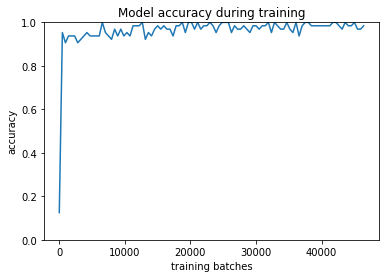

Model has an accuracy of 97.30%


In [191]:
plot_learning_rate(accuracies)
accuracy = test_model(model_basic, test_set)
print('Model has an accuracy of {:0.2f}%'.format(accuracy * 100))

Now putting it all together, we can see that the network quickly increases to 90% accuracy and then slowly increases to around 97%. Not that great accuracy but at least the network learnings something from the data set. Control checking it to the test set we can see that the learning generalizes.

The following code block fetches images and labels of the handwritten numbers. It fetches a single number from test_set and prints it out as an image to allow the user to know which handwritten number the network tried to predict. Together with the previously mentioned function, this allows to show the number that the network tries to guess together with the graph that displays the network's accuracy. Most of the times the network gets confused the digit is poorly written although a human can see what it is.

Predicted Digit:  1
Original Label:  1


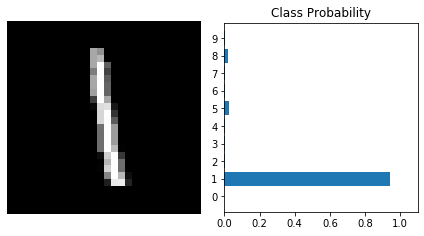

In [14]:
images, labels = next(iter(test_set))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit: ", probab.index(max(probab)))
print("Original Label: ", labels[0].item())
plot_image_classification(img.view(1, 28, 28), ps)

# 3. Confusion matrix

In order to further evaluate the accuracy of our neural network, we constructed a confusion matrix. The purpose for creating it is to help us understand which digits the network misclassified and with what other digits. With this analysis, it would be easier to try to devise a strategy that tackles certain digit misclassifications for instance that network has a particular difficulty classifying.

The way the _plot_confusion_matrix_ function below works is that it uses the test data labels namely the _actual labels_ and correspondingly their _predicted labels_ counterparts, the _classes_ (the names of the labels in the classification), _title_ and _cmap_ (color used in the plot). In addition, the when plotting the function applies intensity, so the bigger the number for a particular cell, the more intense the color, also a color bar is displayed to aid the intensity understanding.

In [53]:
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    fig, ax = plt.subplots(figsize = (10, 10))
    im = ax.imshow(cm,cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    x_classes = classes 
    classes.reverse()
    
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),       
           xticklabels=x_classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), ha="right")

    # Loop over data dimensions and create text annotations.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            color="white" if cm[i, j] > 500 else "black"
            ax.text(j, i, format(cm[i, j]), ha="center", va="center", color=color)
    
    ax.set_xticks(np.arange(cm.shape[1]+1)-.5)
    ax.set_yticks(np.arange(cm.shape[0]+1)-.5)
    plt.show()

The following code block labels the numbers we want to illustrate, ranging from 0 to 9. It also calls out the function defined above with the data collected from the training function.

## 3.1 Basic Model Confusion Matrix

Number Of Images Tested = 10000
Number of correct number guesses = 9730

Model Accuracy = 0.973


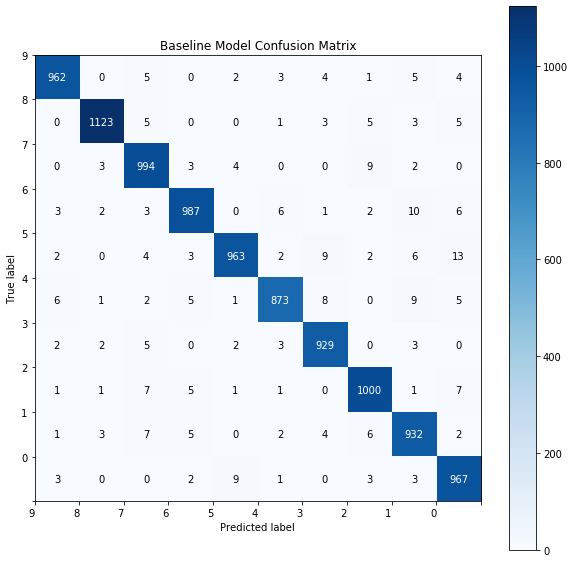

In [193]:
correct_count, all_count = 0, 0
predicted_labels = []
actual_labels = []
for images,labels in test_set:
    for i in range(len(labels)):
        img = images[i].view(1, 784)
        with torch.no_grad():
            logps = model_basic(img)

        ps = torch.exp(logps)
        probab = list(ps.numpy()[0])
        pred_label = probab.index(max(probab))
        true_label = labels.numpy()[i]
        
        predicted_labels.append(pred_label)
        actual_labels.append(true_label)
        
        if(true_label == pred_label):
            correct_count += 1
        all_count += 1

print("Number Of Images Tested =", all_count)
print("Number of correct number guesses =", correct_count)
print("\nModel Accuracy =", (correct_count/all_count))

label_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,]
plot_confusion_matrix(predicted_labels, actual_labels, label_list, title='Baseline Model Confusion Matrix')

__The Confusion Marix of the Basic Model__ with _accuracy_ 0.9735 shows us a number of cases where the network made errors. The most misclassified digit for another digit is the zero, which was misclassified for a five. However, the overall most misclassified digit was two. 

# 4. Creating the CNN and searching for hyper params

After understanding and implementing the basic neural network, the next step was to implement a convolutional neural network (CNN) in order to obtain better results.

As mentioned earlier we realized that searching for hyper parameters manually is inefficient and we decided that we would do a search to find a good set instead. Deciding between doing a random search and a grid search, we settled for grid search even though it would require us go through a lot of combinations. In order to reduce the number of combinations we had to limit us to very few values of each parameter. Because it still would become a lot of combinations we decided to only do one epoch for each model and then selecting the best performing ones to test further with more epochs. The disadvantage of this approach is that me might have missed out on models which performed poorly for the first epoch but that might have performed much better when training them longer.

## 4.1 CNN Model

In [46]:
class Model_Custom_CNN(nn.Module):
    def __init__(self, hyper_params):
        super(Model_Custom_CNN, self).__init__()
        self.hyper_params = hyper_params
        
        layers = []
        for n in self.hyper_params['conv_layers']:
            conv_layer = nn.Conv2d(
                n['in_channels'], 
                n['out_channels'], 
                n['kernel_size']
            )
            layers.append(conv_layer)
            layers.append(self.get_activation_function())
            layers.append(nn.MaxPool2d(2))
        self.conv = nn.Sequential(*layers)
        
        layers = []
        for i in range(len(self.hyper_params['regular_layers']) - 1):
            nr_in = self.hyper_params['regular_layers'][i];
            nr_out = self.hyper_params['regular_layers'][i + 1];
            layers.append(nn.Linear(nr_in, nr_out))
            layers.append(self.get_activation_function())
        
        # The output layer should not have an activation function
        layers.pop()
        
        self.net = nn.Sequential(*layers)
          
        learning_rate = self.hyper_params['learning_rate']
        momentum = self.hyper_params['momentum']
        optimizer = self.hyper_params['optimizer']
        if optimizer == 'SGD':
            self.optimizer = optim.SGD(self.parameters(), lr=learning_rate, momentum=momentum)
        elif optimizer == 'Adam':
            self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        else:
            raise Exception('Invalid optimizer')
            
        criterion = self.hyper_params['criterion']
        if criterion == 'CrossEntropy':
            self.criterion = nn.CrossEntropyLoss()
        else:
            raise Exception('Invalid criterion')
        
    def get_activation_function(self):
        fun = self.hyper_params['activation_function']
        if fun == 'ReLU':
            return nn.ReLU()
        if fun == 'Sigmoid':
            return torch.nn.Sigmoid()
        if fun == 'Swish':
            return Swish()
        
        
    def forward(self, tensor):
        tensor = self.conv(tensor)
        tensor = tensor.reshape(tensor.size(0), -1)
        return self.net(tensor)
    
    
    def fit(self, tensor, labels):
        result = self(tensor)
        
        self.optimizer.zero_grad()
        loss = self.criterion(result, labels)
        loss.backward()
        self.optimizer.step()
        
        _, predictions = torch.max(result, 1)
        total = tensor.size(0)
        nr_correct = torch.sum(predictions == labels).item()
        
        return nr_correct / total

Instead of a hard coded network like our previous model, this model takes in a dictionary of hyper parameters and then constructs the layers from it. This allows us to have a varying number of layers and different activation functions, etc. We have also added support for convolutional layers. For each convolutional layer we have one activation function and then a pooling layer, which we based on [2]. The reason that we have chosen to have a dictionary instead of multiple parameters to the constructor is that we wanted an easy way to save, load and print the models parameters.

__forward__ works the same as the previous model except that it runs the convolutional layers before convertering the tensor to a vector.

__fit__ is exactly the same as the previous model

## 4.2 Hyper Parameter Tuning with Grid Search

In [22]:
def hyper_parameter_permutations():
    layer_sizes = [32, 64, 128]
    hidden_layers = [list(n) for n in itertools.permutations(layer_sizes, 1)]\
                  + [[a, b] for (a, b) in itertools.permutations(layer_sizes, 2) if a >= b]
    
    channel_sizes = [4, 8, 16]
    conv_layers = [list(n) for n in itertools.permutations(channel_sizes, 1)]\
                + [[a, b] for (a, b) in itertools.permutations(channel_sizes, 2) if a <= b]
    
    kernel_sizes = [5]
    activation_functions = ['ReLU', 'Sigmoid', 'Swish']
    criterions = ['CrossEntropy']
    
    #Adding momentum directly to the optimizer since it's only used for SGD
    optimizers = [('SGD', 0.1), ('SGD', 0.5), ('SGD', 1.0), 'Adam']
    learning_rates = [0.1, 0.01, 0.001]

    return itertools.product(
        hidden_layers,
        conv_layers,
        kernel_sizes,
        activation_functions,
        criterions,
        optimizers,
        learning_rates
    )

In [23]:
class Swish(nn.Module):
    def forward(self, input_tensor):
        return input_tensor * torch.sigmoid(input_tensor)

The function hyper_parameter_permutations creates a list of all different permutations that we want to test in our search. It is hard to choose a good search range, especially when we are limited to so few values for each parameter. We used LeNet-5 [3] as a reference and picked values around that network's range.

We choose to test three different activation functions. Sigmoid and ReLU which two commonly used activation functions, and
Swish which is a fairly new activation function that were suggested by Google Brain [4] that supposedly should perform better than or equal to ReLU. Since there is no predefined Swish function in Pytorch we had to create a class for it.

For the optimizers we tried stochastic gradient descent with different momentums and Adam which is another popular optimizer.

Searching through the Internet for good loss functions for classification problems, we only found NLLLoss (The negative log likelihood loss) and Cross Entropy loss that worked with our existing model. Since Cross Entropy Loss is the same as NLLLoss and LogSoftMax combined we are only using that one [5].

Even though we had already limited us to just a few search parameters we needed to reduce the amount of combinations even further. We decided to not search for different kernel sizes in the convolutional layers and different batch sizes since we thought activation functions and optimizers would be more interesting. This left us with just 1296 different combinations to go through which meant that the search would only take a few hours.

*permutation_to_dictionary* converts the hyper parameter permutations generated by *hyper_parameter_permutations* into the dictionary format that our model accepts.

In [24]:
def permutation_to_dictionary(hidden_layers, channel_sizes, kernel_size, act_fun, criterion, optimizer, learning_rate):
    conv_layers = []
    in_channels = 1
    side_length = 28
    for channel_size in channel_sizes:
        out_channels = channel_size
        conv_layers.append(
            {
                'in_channels': in_channels,
                'out_channels': out_channels,
                'kernel_size': kernel_size
            }
        )
        in_channels = out_channels
    
        side_length -= kernel_size - 1
        side_length //= 2
        
    if type(optimizer) is tuple:
        momentum = optimizer[1]
        optimizer = optimizer[0]
    else:
        momentum = 0
    
    regular_layers = [side_length * side_length * out_channels] + hidden_layers + [10]
    return {
        'conv_layers': conv_layers,
        'regular_layers': regular_layers,
        'activation_function': act_fun,
        'optimizer': optimizer,
        'criterion': criterion,
        'learning_rate': learning_rate,
        'momentum': momentum
    }

Here is the actual search, where we are searching for the model with the highest accuracy by going through all permutations, constructing a model for each, training it and comparing the model to the test set. Then storing the model’s hyper parameters along with the accuracy in a sorted list from best accuracy to worst. In our first run we ran out of memory so we had to wrap the logic for each model in a separate function so that we could run the garbage collector.

In [67]:
def grid_search():
    gc.collect()
    before = time.time()

    models = []
    
    permutations = list(hyper_parameter_permutations())
    
    print("Searching through {} permutations".format(len(permutations)))

    i = 0
    for n in permutations:
        grid_search_helper(n, models)
        break
        i += 1
        
        if i % 100 == 0:
            print("{} complete, time elapsed: {:.2f} minutes".format(i, (time.time() - before) / 60))
            
        if i % 500 == 0:
            gc.collect()

    models.sort(key=lambda n: n[0], reverse=True)

    after = time.time()
    print("Done, took {:.2f} minutes".format((after - before) / 60))
    
    return models

# Wrapper function that allows the garbage collector to run
def grid_search_helper(permutation, models):
    hyper_params = permutation_to_dictionary(*permutation)
    model = Model_Custom_CNN(hyper_params)
    train_model(1, model, training_set)
    accuracy = test_model(model, test_set)
    models.append((accuracy, model.hyper_params))


The following two functions below simply write information to a file or read it. This is done to avoid performing our lengthy grid search multiple times, instead we just use the gathered information from a written file.

In [57]:
def write_json(params, filename):
    params_json = json.dumps(params)
    f = open(filename, "w")
    f.write(params_json)
    f.close()
    
def read_json(filename):
    f = open(filename, "r")
    params = json.loads(f.read())
    f.close()
    return params

Here we run the search and save the result to a file (an ordered list from best to worst accuracy).

In [ ]:
epochs = 1
models = grid_search()
write_json(models, "one_epoch_models.json")

In order to get some sense on which parameters that performed well, we decided to plot their average position in the list. The following function add the positions of each of the values for all parameters and then averages them. Then displays a plot of it.

In [138]:
def plot_hyper_param_bars(hyper_parameters, title):
    # Dictionary that keeps track of all the hyper parameter positions.
    position_map = {
        "optimizers": {
            "SGD 0.1": [],
            "SGD 0.5": [],
            "SGD 1.0": [],
            "Adam": []
        },
        "activation functions": {
            "Sigmoid": [],
            "ReLU": [],
            "Swish": []
        },
        "learning rates": {
            "0.1": [],
            "0.01": [],
            "0.001": []
        },
        "channels from conv layer 1": {
            "4": [],
            "8": [],
            "16": []
        },
        "channels from conv layer 2": {
            "0": [],
            "8": [],
            "16": []
        },
        "nodes in hidden layer 1": {
            "32": [],
            "64": [],
            "128": []
        },
        "nodes in hidden layer 2": {
            "0": [],
            "32": [],
            "64": []
        }
    }
    
    # Aggregate all the positions of the hyper parameters
    for i, params in enumerate(hyper_parameters):
        position_map['learning rates'][str(params['learning_rate'])].append(i)
        position_map['activation functions'][params['activation_function']].append(i)
        position_map['channels from conv layer 1'][str(params['conv_layers'][0]['out_channels'])].append(i)
        position_map['nodes in hidden layer 1'][str(params['regular_layers'][1])].append(i)
        
        if len(params['conv_layers']) == 2:
            nr_channels_second_layer = params['conv_layers'][1]['out_channels']
        else:
            nr_channels_second_layer = 0
            
        if len(params['regular_layers']) == 4:
            nr_nodes_second_layer = params['regular_layers'][2]
        else:
            nr_nodes_second_layer = 0
            
        position_map['channels from conv layer 2'][str(nr_channels_second_layer)].append(i)
        position_map['nodes in hidden layer 2'][str(nr_nodes_second_layer)].append(i)
        
        if params['optimizer'] == 'SGD':
            position_map['optimizers']['SGD ' + str(params['momentum'])].append(i)
        else:
            position_map['optimizers'][params['optimizer']].append(i)

    labels = []
    data = []
    xdata = []
    
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:brown', 'tab:purple', 'tab:cyan']
    
    bar_colors = []
    legends = []

    # Construct the data for the plot
    xpos = 0
    xspacing = 5
    for i, (hyper_param, group) in enumerate(position_map.items()):
        for key, value in group.items():
            xpos += xspacing
            xdata.append(xpos)
            labels.append(key)
            data.append(value)
            bar_colors.append(colors[i])
        xpos += xspacing
        xdata.append(xpos)
        data.append([])
        labels.append(' ')
        bar_colors.append(colors[i])
        legends.append(mpatches.Patch(color=colors[i], label=hyper_param))
    xdata.pop()
    data.pop()
    labels.pop()
    
    # Convert from lists of positions to avrage position
    data = [sum(values) / max(len(values), 1) for values in data]
    
    fig=plt.figure(figsize=(20, 7))
    s = plt.subplot(1,1,1)
    s.set_xticks(xdata)
    s.tick_params(labelrotation=45)
    s.set_xticklabels(labels)
    s.set_title(title, fontsize=18)
    plt.bar(xdata, data, 4, color=bar_colors)
    
    #red_patch = mpatches.Patch(color='red', label='The red data')
    plt.legend(handles=legends)


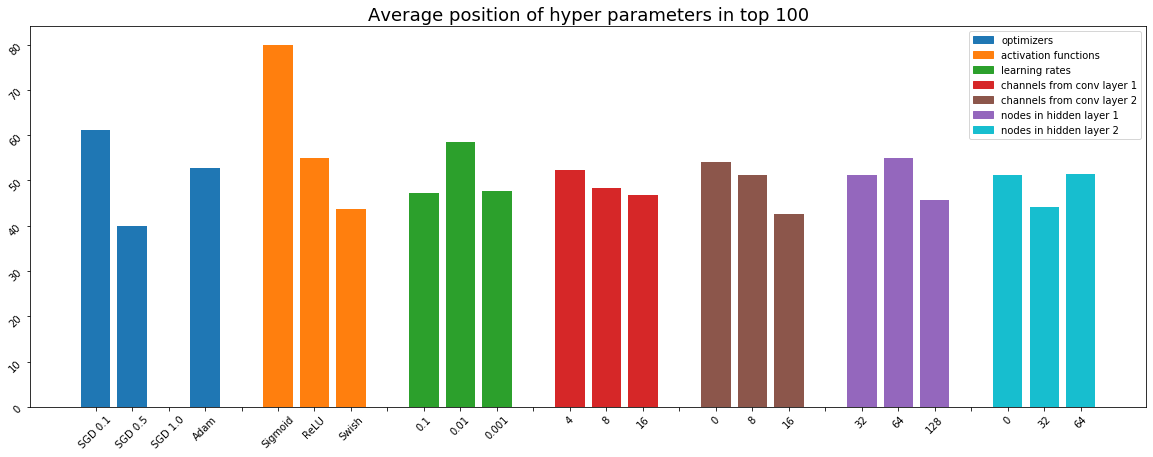

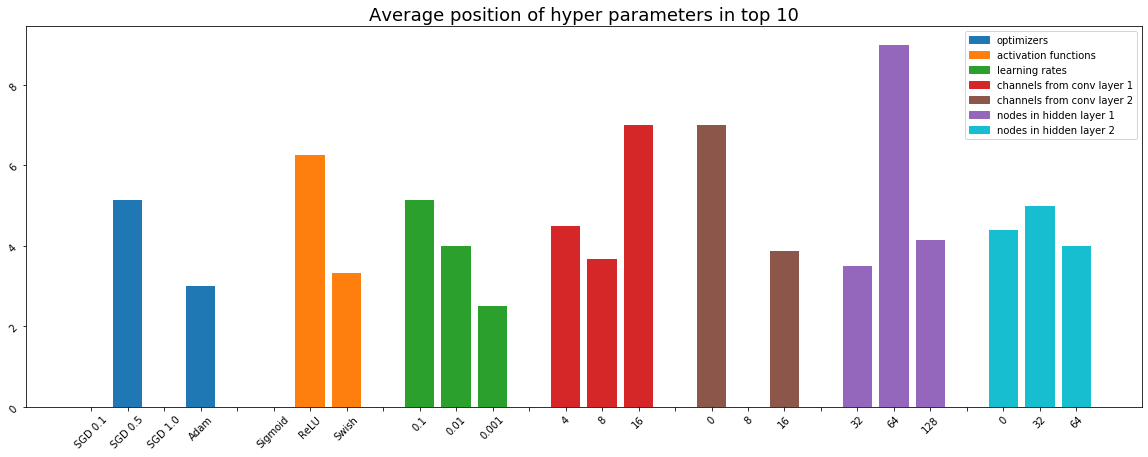

In [139]:
# The loaded list is sorted from best to worst
hyper_parameters = [p for (_, p) in read_json("one_epoch_models.json")]
plot_hyper_param_bars(hyper_parameters[:100], "Average position of hyper parameters in top 100")
plot_hyper_param_bars(hyper_parameters[:10], "Average position of hyper parameters in top 10")

By plotting the average positions of the top 100 and top 10 hyper parameter configurations we can get a sense of which of them that performed well. This doesn't account for that some values might perform really well for a very specific configuration but poorly for most of the configurations. It also doesn't show how many of each different values that were averaged. So for example there might be alot of ReLU in the top 100 and only a few Swish activation functions and still Swish shows a better average position. That said, this might give some insight.

We tried the different momentums 0.1, 0.5 and 1.0 for stochastic gradient descent (SGD). Both 0.1 and 1.0 seems to have been bad values, but a momentum of 0.5 outperformed Adam for top 100. Adam still performed better than SGD for top 10, which is not that surprising since Adam is popular because it trains fast.

Looking at top 100 there doesn't seem to be that much difference between the learning rates, but for for top 10 the learning rate of 0.001 came out ahead. It would be interesting to see if even lower values of the learning rate would perform better or if it would be come to small to learn efficiently.

The different number of out channels from the first convolutional layer gave similar results for top 100 with 16 channels falling behind for the best networks. Interestingly it seemed to be better either having no second convolutional layer or sixteen out channels. Which could mean that it is better to skip the second convolutional layer if you have a to small number of out channels.

The number of nodes in the hidden layers performed about the same for top 100 and also for top 10. Except for 64 nodes in the first hidden layer which performed worse. This was unexpected since we thought that the number of nodes in the hidden layers would have a greater impact than what we got here. Maybe we would get greater differences if we tried much larger values for the layers.

## 4.3 Training networks for multiple epochs

Now that we have the models that performed well for the one epoch search, we want to see if they perform better when we run them for multiple epochs. Since we can’t run all of them we have selected the ten best models from the previous search. In the code below we train the models and plot their accuracies for each epoch. All of them improved a little. Multiple of them reached the same top accuracy of 99,7% at some point during the training.

In [129]:
display(HTML("<table><tr><td><img src='img/top_10_models.png'>"))

In [ ]:
top_models_num = 10
epochs = 20
models_accuracies = {}

time_start = time.time()
model_id = 0

for model_data in models_params_data[:top_models_num]:
    
    model_hyper_params = model_data[1] # select the dictionary with the yper params for each model
    models_accuracies[model_id] = []
    
    model = Model(model_hyper_params)

    for epoch in range(1, epochs+1):
        
        train_a_model(model)
        
        accuracy = test_model(model, test_set)
        
        models_accuracies[model_id].append(accuracy)        
        
    model_id+=1

# save all accuracies to a top_models_accuracies.json
params_json = json.dumps(models_accuracies)
f = open("top_models_accuracies", "w")
f.write(params_json)
f.close()

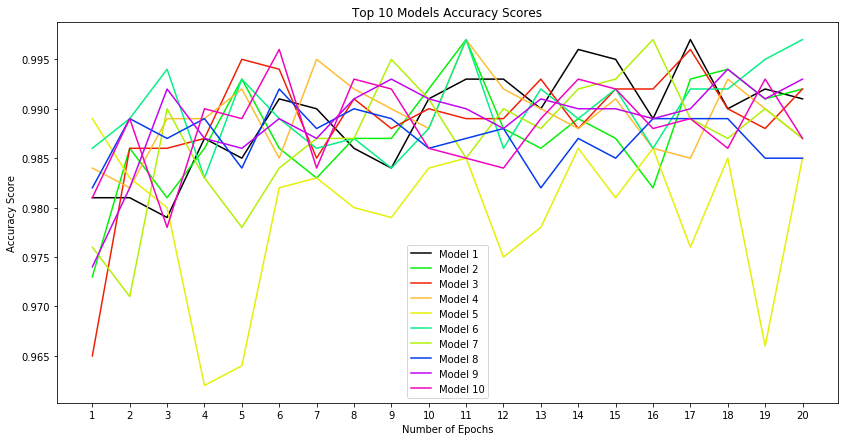

In [97]:
epoch_range = list(range(1, epochs+1, 1))

colors = ['#000000','#04f108', '#f11f04', '#FFBD33', '#e5f104', '#04f186', '#b2f104', '#043bf1', '#c204f1', 
          '#f104be']


fig, ax = plt.subplots(figsize=(14, 7))
plt.title("Top 10 Models Accuracy Scores")

for i in range(top_models_num):
    ax.plot(epoch_range, models_accuracies[i], colors[i], linewidth=1.5, label="Model "+str(i+1))
    
ax.legend()
ax.set_ylabel("Accuracy Score")
ax.set_xlabel("Number of Epochs")
plt.xticks(np.arange(1, epochs+1, step=1))
plt.show()

The fourth model out of the grid search were one of the models that performed the best with 99,7% with more epochs. It also had lower learning rate than the other models. Therefore, we decided to run 50 epochs on this specific model to check if it performs even better and to compare it to the basic model and the model we found online.

In [201]:
hyper_params = read_json("one_epoch_models.json")[3][1]
CNN_model = Model_Custom_CNN(hyper_params)
accuracy = train_model(50, CNN_model, training_set)
plot_learning_rate(accuracy)

In [207]:
accuracy = test_model(CNN_model, test_set)
print('Model has an accuracy of {:0.2f}%'.format(accuracy * 100))

Model has an accuracy of 98.94%


These are the hyper parameters of the selected model.

In [202]:
print(json.dumps(hyper_params, indent=2))

{
  "conv_layers": [
    {
      "in_channels": 1,
      "out_channels": 8,
      "kernel_size": 5
    },
    {
      "in_channels": 8,
      "out_channels": 16,
      "kernel_size": 5
    }
  ],
  "regular_layers": [
    256,
    32,
    10
  ],
  "activation_function": "Swish",
  "optimizer": "Adam",
  "criterion": "CrossEntropy",
  "learning_rate": 0.001,
  "momentum": 0
}


# 5. External CNN

After creating our own CNN model and evaluating both the training accuracy and testing accuracy. In order to further evaluate our custom model performance, we decided to find an external CNN model and compare it.

An external CNN model was found online [6] which both explains how each part of the network works as well as provides the full source code for other people to test it.

The following code block imports the same dataset of handwritten digits as the previous neural network. However, it splits the data into 3 different arrays, train_dataloader, val_dataloader and test_dataloader. The first array contains 60000 training images for the network to learn from. The second array is used to validate the network to determine whether the network is still providing the correct results, to determine if it is underfitting or overfitting. The third array is used to further test and validate the results once more for correctness.

In [203]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

mnist_valset, mnist_testset = torch.utils.data.random_split(mnist_testset, [int(0.1 * len(mnist_testset)), int(0.9 * len(mnist_testset))])

train_dataloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(mnist_valset, batch_size=32, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(mnist_testset, batch_size=32, shuffle=False)

print("Training dataset size: ", len(mnist_trainset))
print("Validation dataset size: ", len(mnist_valset))
print("Testing dataset size: ", len(mnist_testset))

Training dataset size:  60000
Validation dataset size:  1000
Testing dataset size:  9000


The following code block creates the CNN model. It consists of 2 convolutional layers, 1 pooling layer, 2 hidden layers and an output layer. It also creates a feed-forward function that is used when sending data to the model.

In [204]:
class Model_External_CNN(torch.nn.Module):
    def __init__(self):
        super(Model_External_CNN, self).__init__()
        self.conv_1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv_2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.max_pool2d = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear_1 = torch.nn.Linear(7 * 7 * 64, 128)
        self.linear_2 = torch.nn.Linear(128, 10)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.conv_1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv_2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = x.reshape(x.size(0), -1)
        x = self.linear_1(x)
        x = self.relu(x)
        x = self.dropout(x)
        pred = self.linear_2(x)

        return pred

The code below simply creates a new instance of the model, defines the criterion and the optimizer functions. It also initializes lists that will be used for measuring the loss when training and validating the data.

In [205]:
model_external = Model_External_CNN()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_external.parameters(), lr=0.001)

train_loss = list()
val_loss = list()
best_val_loss = 1

The code block below is the core part of the external CNN. Here a for loop iterates over an n amount of epochs. At each iteration, the network is trained with the training dataset. Afterwards, the CNN is validated with more data using a separate validation dataset. At each iteration, the loop prints out the training and validation loss and the measured accuracy.

In [206]:
time0 = time()
epochs = 50

for epoch in range(epochs):
    total_train_loss = 0
    total_val_loss = 0

    model_external.train()
    
    # training
    for itr, (image, label) in enumerate(train_dataloader):

        optimizer.zero_grad()

        pred = model_external(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    total_train_loss = total_train_loss / (itr + 1)
    train_loss.append(total_train_loss)

    # validation
    model_external.eval()
    total = 0
    for itr, (image, label) in enumerate(val_dataloader):

        pred = model_external(image)

        loss = criterion(pred, label)
        total_val_loss += loss.item()

        pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

    accuracy = total / len(mnist_valset)

    total_val_loss = total_val_loss / (itr + 1)
    val_loss.append(total_val_loss)

    print('\nEpoch: {}/{}, Train Loss: {:.8f}, Val Loss: {:.8f}, Val Accuracy: {:.8f}'.format(epoch + 1, epochs, total_train_loss, total_val_loss, accuracy))

    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        print("Saving the model state dictionary for Epoch: {} with Validation loss: {:.8f}".format(epoch + 1, total_val_loss))
        torch.save(model.state_dict(), "model.dth")
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Training Time (in minutes) = 125.15997711817424


Finally, the following code block runs over a testing dataset, that consists of 9000 images. This is used to finalize the results and determine if the trained network provided accurate results.

In [208]:
# test model for external CNN

correct_count, all_count = 0, 0
predicted_labels_external_CNN = []
actual_labels_external_CNN = []

for images,labels in test_dataloader:
    result = model_external(images)
    
    _, predictions = torch.max(result, 1)
    predicted_labels_external_CNN.extend(predictions.tolist())
    actual_labels_external_CNN.extend(labels.tolist())
    all_count += images.size(0)

In [210]:
accuracy = test_model(model_external, test_set)
print('Model has an accuracy of {:0.2f}%'.format(accuracy * 100))

Model has an accuracy of 92.49%


# 6. Comparing results

After implementing the basic neural network as well as the custom CNN, it was important to compare the results together with the external CNN model found online. Because this is a classification problem, the aspects we decided to measure were the time it took to train the model, evaluate how well did the model perform for each digit as well as compare the network's accuracy.

Below, multiple confusion matrices can be seen that correspond to each model. Comparing the neural network's and the external CNN confusion matrices, it can be seen that the external one performed a lot better when it came to guessing the numbers. [write example of certain numbers being recognized by the network]

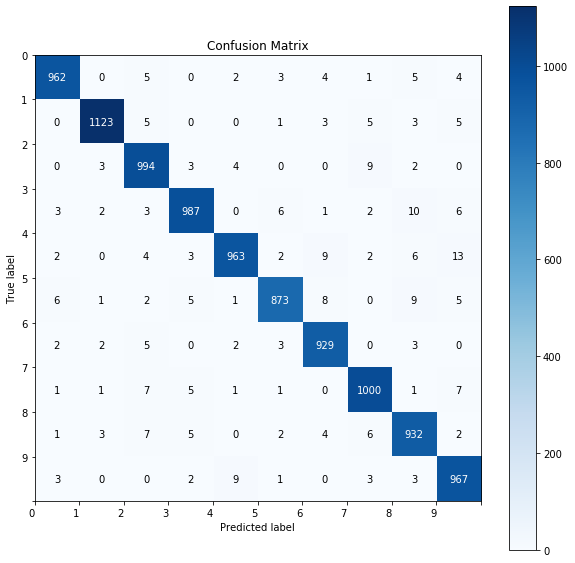

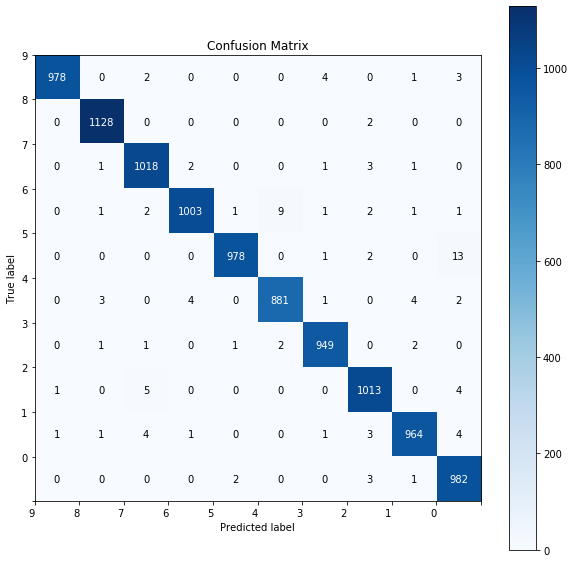

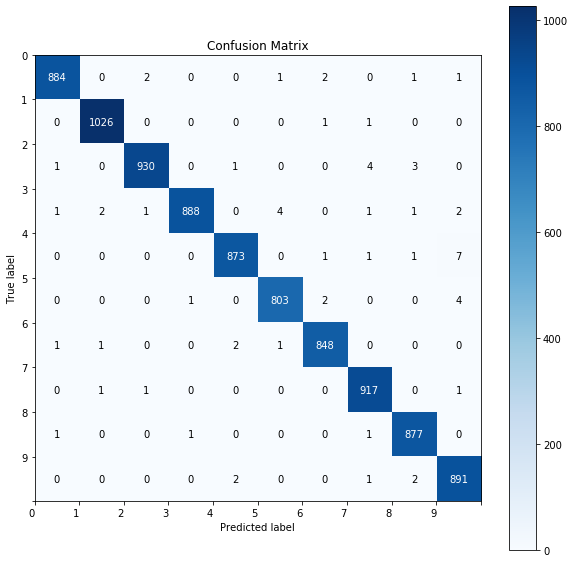

In [209]:
# Plot confusion matrix of the simple neural network
plot_confusion_matrix(predicted_labels, actual_labels, label_list)

# Plot confusion matrix of our custom CNN
plot_confusion_matrix(predicted_labels_custom_CNN, actual_labels_custom_CNN, label_list)

# Plot confusion matrix of the external CNN
plot_confusion_matrix(predicted_labels_external_CNN, actual_labels_external_CNN, label_list)

The images below showcase all three model's confusion matrices. The first confusion matrix (top) belongs to the basic model. By looking at it, it can be seen that there are quite a few misclasifications. The number five had the largest error rate out of all the numbers. Most of the misclasificatios occured on the number 5 where the network thought it was 0.

The second confusion matrix (middle) belonds to our CNN model. The matrix shows that there were a lot less misclassifications compared to the basic model. Interestingly enough, most of the misclasifications occured on the number 5 as well, where the network thought it was also 0. This might indicate that a lot of digits 5 were poorly written.

The confusion of the external CNN looks sparse, with a few higher numbers and the rest making missclassification of up to 5 times per class. The highest misclassidfied number is 0 and it was predicted for 5 for 12 cases of the testset. The overall performance of the network is very satisfactory in terms of distribution of diifferent misclassifications types, in other words there are not certain labels misclasified significantly a lot more for others.

In [177]:
display(HTML("<table><tr><td><h3><img src='img/basic_model_training_time.png'></td><td><img src='img/custom_cnn_training_time.png'></td><td><img src='img/external_cnn_training_time.png'></td></tr></table>"))

,,


After training all three models, we gathered results about the training time of each model. As seen on the image on the left, the training time for the basic model only took around 8 minutes. This makes sense, because the model itself has only a few layers. Even if the network trained faster, it still did not achieve the same accuracy as the other 2 networks. The second model, our own CNN, took 2 hours to train. Compared to the other 2 models, ours contain the most layers, hence the reason why it took the longest. However, our model achieved the best results in terms of accuracy, so the extra training time was worth it. The external CNN model took over an hour to train, which is faster than our own CNN, however it did not achieve the exact same accuracy, being behind around 1-2%.

# 7. The Social, Economic and Societal Aspects of the work

Handwritten digits recognition can be utilized in the following areas:
 - recognizing zip codes on letters that could aid postal mail sorting
 - recognize car plates digits for survailance 
 - recognizing house address or mailbox numbers 
 
 These example applications can have significant impact in domain of applicatin.
 
 Detecting digits from mail and entering this information in a database can be a slow and repetitive process that could possibly be partially or fully automated, saving resources and increasing performance by being able to process more mail at a faster rate with less resources, lowing the price that customers need to pay to have their mail safely delivered. 
 
 Another instance is when digit recognition is used to recognize car plates that can be used by law inforcement authorities to track vehicles with suspicious behaviour.
 
 Further utility of detecting digits can be used for recognizing house address or mailbox numbers that can be used by autonomous delivery systems such as drones that recognize such images to further make sure that the address is correct.
 
 The above mentioned applications can be economically beneficial to main senders and receivers as it would decrease cost and improve delivery time. The recognition of car plates could be useful to government authorities, however it can also be misused by someone for mischivious purposes. In the third application area similarly it can be used to better insure more accurate delivery of latters and packets but also it can be misused by some for delivering something that the receiver does not want such as spam mails. 
 
All these aspects have to taken into consideration when applications of hand written digits or digit recognition in general is to be implemeted and put in the real world. Application have to be monitored and fairness and security should be insured especially when human interact with such technology.

# 8. Challenges

During the project implementation, there were several challenges that the group had to face. Of the main challenges occured during the initial phase, where the group had to implement the simple neural network. Due to the fact that every group member had different experiences, it took some time to ensure that every member understand the concept behind neural networks.

# 9. Related work

After implementing our CNN, our next goal was research several papers related to the same domain. The purpose behind this was for us to compare our CNN to the ones specified in the paper. This allowed us to understand whether our project was going towards the right direction and if we could achieve similar results.

## Best Practices for Convolutional Neural Networks Applied to Visual Document Analysis

The first paper [9] states that CNN with input, output and 100 hidden layers, as well as the large training data set are the most important practices to gain a superior result “the optimal performance” on MNIST data. They use Elastic Distortion to expand the training data set via applying displacement fields to images in order to generate simple distortions like translation, rotation and skewing. “This is done by computing for every pixel a new target location with respect to the original location. The new target location, at position (x,y) is given with respect to the previous position”[9]. At the end they found that the quality of the learning systems depends on the quality and the size of training data set. As well as that distortions increase the result on MNIST data ultimately.

## Study and Observation of the Variations of Accuracies for Handwritten Digits Recognition with Various Hidden Layers and Epochs using Convolutional Neural Network

The second paper [10] analyses how the hidden layers in CNN affects the overall performance of the network by using the Modified National Institute of Standards and Technology (MNIST). Then it shows that CNN have attained the same effect of human level accuracies in various image recognition assessments including handwritten digits, traffic sign, etc which leads to extending the acceptance of CNN in recent years. For handwritten digits recognition this specific CNN contains seven layers. One input layer of the network consists of 748 neurons, five hidden layers (convolution layer 1, pooling layer 1, convolution layer 2, pooling layer 2 and fully connected layer one respectively) and one output layer of ten neurons.
To increase the performance of the model, ReLU activation function was used at the end of all convolutional layers and in fully connected layers. As well as a SOFTMAX activation function is used at the end of the output layer. 
Dropout regularization techniques were used to minimize the probability to overfit the network. It is used at the fully connected layer to learn various independent representations of the same data by arbitrarily disabling individual activation while training the system.
It concludes that they got the best and worst loss rates when there was no dropout which means in the case when there are a variety of combinations of layers. However, they found that the total performance gets better if the convolutional layers are placed consecutively.

Having read both of the papers, it allowed us to understand that we could achieve similar results and it also gave us an idea to augment our data as an extension similar to the one mentioned in the first paper.

# 10. Possible extensions

### 10.1 Data Augmentation

With the help of the idea of augmenting the data in the first research paper, the group came up with the idea to augment our dataset by basically thickening the written digits. 

We created our own approach of augmenting the training set. It consists of taking an image and observing if a given pixel is within a _threshold_ higher than the one specified, we used _threshold = 0.5_ as it produced better results after experimenting with a few values. Next we have _whithen_pix_per_row_ parameter that determines the number of pixels we can whiten per row in the image, we have set it _whithen_pix_per_row = 3_ as again it produced better results in our trials. Then there is the _brightness_ parameter that defines what value should the whitened parameter be set to, we picked _brightness = 1_ because we wanted it to thicken to max so the effect would be bigger. The allowed to be thickened should be next to a pixel that passes the _threshold_ predefined. 

Furthermore, training on a more diverse dataset is fundamental to creating a more flexible model that is better able to capture a more diverse set of possible ways of writing images. One such common practice is that we write images that are slightly or more thicker at certain points we try to compute with our augmentation method.

With this simple method of roughly thickening the digits, our aim to enlarge the dataset by data augmentation that is sensible and corresponds to every potential way these images could have been written and also corresponding to the content and high level features of our MNIST training dataset. 

Data augmentation can improve accuracy on the test set and also it can be used to prevent overfitting and potentially bring closer train and test accuracies.

As demonstrated below, these images are samples of how the digits were thickened from the training data.

In [11]:
display(HTML("<table><tr><td><img src='img/aug_data_examples.PNG'></td><td><img src='img/aug_data_6_digits.PNG'></td></tr></table>"))

,


In [ ]:
def data_augment_thicken(images):   
    threshold = 0.5
    whithen_pix_per_row = 2
    brightness = 1

    augment_batch = torch.tensor([])

    j = 0
    for img in images:

        img_flat = img.view(1, 784)
        ind = 0

        row_pix_num = 0
        whithen_num = 0
        rows_passed = 0

        for pixel in img_flat[0][:]:
            if pixel > threshold:
                img_flat[0][ind] = brightness

                if whithen_num < whithen_pix_per_row and row_pix_num > 3 and row_pix_num < 25:
                    if img_flat[0][ind-1] < threshold:
                        img_flat[0][ind-1] = brightness
                        whithen_num+=1

                    if img_flat[0][ind+1] < threshold:
                        img_flat[0][ind+1] = brightness
                        whithen_num+=1
            else:
                pass

            ind += 1

            row_pix_num +=1
            if row_pix_num/28 == int(row_pix_num/28):
                rows_passed +=1
                row_pix_num = 0
                whithen_num = 0

        if augment_batch.shape[0] == 0:
            augment_batch = img_flat.resize_(1,1, 28, 28)

        else:
            augment_batch = torch.cat((augment_batch, img_flat.resize_(1,1, 28, 28)),0)
    return augment_batch

In [ ]:
def train_model_with_aug(model):
    accuracy = []
    for n in range(0, 17):
        for (batch_index, (images, labels)) in enumerate(training_set):
            if n == 0:
                images = images.view(images.shape[0], -1)   
            
            augment_batch = data_augment_thicken(images)        
            acc = model.fit(augment_batch, labels)
            accuracy.append(acc)
            
        augment_accuracies.append(test_model(model, test_set))
    return accuracy

In [ ]:
def train_model_with_aug(model):
    accuracy = []
    for n in range(0, 17):
        for (batch_index, (images, labels)) in enumerate(training_set):
            if n == 0:
                images = images.view(images.shape[0], -1)   
            
            augment_batch = data_augment_thicken(images)        
            acc = model.fit(augment_batch, labels)
            accuracy.append(acc)
            
        augment_accuracies.append(test_model(model, test_set))
    return accuracy

In [ ]:
# here we load the models parameters trained in the grid with 1 epoch
with open('./one_epoch_models.json') as f:
    models_params_data = json.load(f)
    
model = Model(models_params_data[0][1])

accuracies_best = []

# we train one of the best models for 17 epochs since it performed for for this number of epochs
for epoch in range(1, 17+1):
    train_model(model)
    accuracy = test_model(model, test_set)
    accuracies_best.append(accuracy)
    
# here we train for 17 more epochs on augmented data
augment_accuracies = []
accuracy_train = train_model_with_aug(model)
# augment_accuracies hold the values that are in the best_model_with_aug_acc variable below 

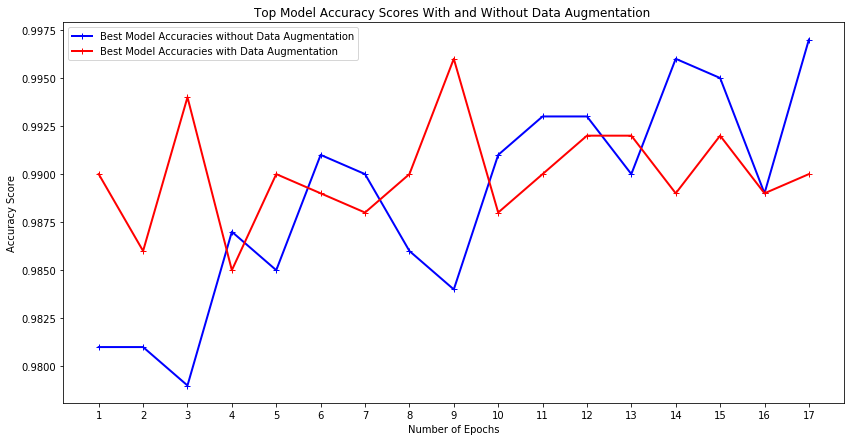

In [2]:
epochs = 17
epoch_range = list(range(1, epochs+1, 1))
best_model_with_aug_acc = [0.99, 0.986, 0.994, 0.985, 0.99, 0.989, 0.988, 0.99, 0.996, 0.988, 0.99, 0.992, 0.992, 0.989, 0.992, 0.989, 0.99]
best_model_acc = [0.981, 0.981, 0.979, 0.987, 0.985, 0.991, 0.99, 0.986, 0.984, 0.991, 0.993, 0.993, 0.99, 0.996, 0.995, 0.989, 0.997]

fig, ax = plt.subplots(figsize=(14, 7))
plt.title("Top Model Accuracy Scores With and Without Data Augmentation ")

ax.plot(epoch_range, best_model_acc, 'b-+', linewidth=2, label="Best Model Accuracy without Data Augmentation")
ax.plot(epoch_range, best_model_with_aug_acc, 'r-+', linewidth=2, label="Best Model Accuracy with Data Augmentation")

ax.legend()
ax.set_ylabel("Accuracy Score")
ax.set_xlabel("Number of Epochs")
plt.xticks(np.arange(1, epochs+1, step=1))
plt.show()


In the above graph we display the accuracies of the model that was found to perform best in the Grid Search and its accuracies are plotted as _Best Model Accuracy without Data Augmentation_ for up to 17 epochs, where it was highest. Along that, we display the accuracies obtained when we trained on the model the _Augmented Data_ after we had trained on the original dataset for 17 epochs. The maximum accuracy that was obtained when we also trained on the _Augmented Dataset_ is __0.996__ at epoch 9. Comparing both results, we can draw to the conclusion that the data augmentation did not have a positive impact on the original data set.

# 11. Conclusion



All in all, we were capable of building our first basic neural network. This allowed us to get a solid foundation of how neural networks work. With this knowledge, we were able to construct a convolutional neural network. We also learned about hyper parameter tuning and how you would go about searching for good values for a network.
 
With the help of Grid Search we were also able to hyper tune a number of neural networks, among which some were able to provide similar results to the ones found online. Further, we trained the top 10 models from the Grid Search for multiple epochs and found out that the accuracies do not improve significantly.

# References

[1] https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627

[2] https://engmrk.com/lenet-5-a-classic-cnn-architecture/

[3] https://www.machinecurve.com/index.php/2019/05/30/why-swish-could-perform-better-than-relu/

[4] https://pytorch.org/docs/stable/nn.html

[5] https://medium.com/@RaghavPrabhu/understanding-of-convolutional-neural-network-cnn-deep-learning-99760835f148

[6] https://towardsdatascience.com/mnist-handwritten-digits-classification-using-a-convolutional-neural-network-cnn-af5fafbc35e9

[7] https://english.stackexchange.com/questions/62586/why-is-1-hand-written-without-a-serif-and-7-without-a-dash

[8] https://www.omniglot.com/language/numerals.htm

[9] Simard, P.Y., Steinkraus, D. and Platt, J.C., 2003, August. Best practices for convolutional neural networks applied to visual document analysis. In Icdar (Vol. 3, No. 2003).

[10] Arif, R.B., Siddique, M.A.B., Khan, M.M.R. and Oishe, M.R., 2018, September. Study and Observation of the Variations of Accuracies for Handwritten Digits Recognition with Various Hidden Layers and Epochs using Convolutional Neural Network. In 2018 4th International Conference on Electrical Engineering and Information & Communication Technology (iCEEiCT) (pp. 112-117). IEEE.